📌 Project Introduction

In this project, we use three different models to classify images of five different venues: decision tree supervised, decision tree semi-supervised and CNN supervised.
This notebook adress only the second model.

📌 Semi-Supervised Learning uses both labeled and unlabeled data to improve accuracy. By leveraging the structure of decision trees, this approach enhances predictions by utilizing all available data

📌 In this Project, we will:

    Analyze customer data provided in data set (EDA= exploratory data analysis) 
    Build two models that can classify images

📌 Install  and importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
from PIL import Image
import dask.bag as db

In [2]:
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import platform
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier

## Decision trees for SemiSupervised learning


#### Code for use gpu in Mac

In [3]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps


📌 Load images

In [5]:
img_path = 'final_dataset'
images = []
labels = []

label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}

In [6]:
device = torch.device('cpu')

In [7]:
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
for name, num in label_map.items():
    for img_name in os.listdir(os.path.join(img_path, name)):
        img_file = Image.open(os.path.join(img_path, name, img_name)).convert('RGB')
        img = transforms(img_file).to(device)
        images.append(img.cpu().numpy())
        labels.append(num)
    print(f"finish to read all {name} images")


X = np.array(images)
Y = np.array(labels)



X = X / 255.0

# Reshape
X_reshape = X.reshape(X.shape[0], -1)


finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images


📌 Train and Test data split

In [8]:
num_cluster = 5
X_train, X_test, Y_train, Y_test = train_test_split(X_reshape,Y, test_size=0.2, random_state=42)

📌 Labeled and unlabeled data split

In [9]:
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)
Y_train_unlabeled = np.full(Y_unlabeled.shape, -1)

In [10]:
X_labeled_train = X_labeled
X_unlabeled_train = X_unlabeled
Y_unlabeled_train = Y_train_unlabeled
Y_labeled_train = Y_labeled

decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, min_samples_leaf=8)


for i in range(0,15):
    lprediction = decision_tree.fit(X_labeled_train, Y_labeled_train)
    
    Y_unlabeled_pred_proba = lprediction.predict_proba(X_unlabeled_train)
    Y_unlabeled_pred = lprediction.predict(X_unlabeled_train)

    
    confidence_scores = np.max(Y_unlabeled_pred_proba, axis=1)
    num_high_confidence = int(0.10 * len(Y_unlabeled_pred))
    top_indices = np.argsort(confidence_scores)[-num_high_confidence:]

    X_high_confidence = X_unlabeled_train[top_indices]
    Y_high_confidence = Y_unlabeled_pred[top_indices]

    
    mask = np.ones(len(X_unlabeled_train), dtype=bool)
    mask[top_indices] = False
    X_unlabeled_train = X_unlabeled_train[mask]
    Y_unlabeled_train = Y_unlabeled_train[mask]

    X_labeled_train = np.concatenate((X_labeled_train, X_high_confidence))
    Y_labeled_train = np.concatenate((Y_labeled_train, Y_high_confidence))

Accuracy: 0.4139; Precision: 0.4041; Recall: 0.4112; F1: 0.4065
Class bar - Accuracy: 0.4071; Precision: 0.3654; Recall: 0.4071; F1-score: 0.3851
Class beach - Accuracy: 0.8165; Precision: 0.7607; Recall: 0.8165; F1-score: 0.7876
Class bookstore - Accuracy: 0.3841; Precision: 0.3681; Recall: 0.3841; F1-score: 0.3759
Class restaurant - Accuracy: 0.2188; Precision: 0.2658; Recall: 0.2188; F1-score: 0.2400
Class subway - Accuracy: 0.2294; Precision: 0.2604; Recall: 0.2294; F1-score: 0.2439


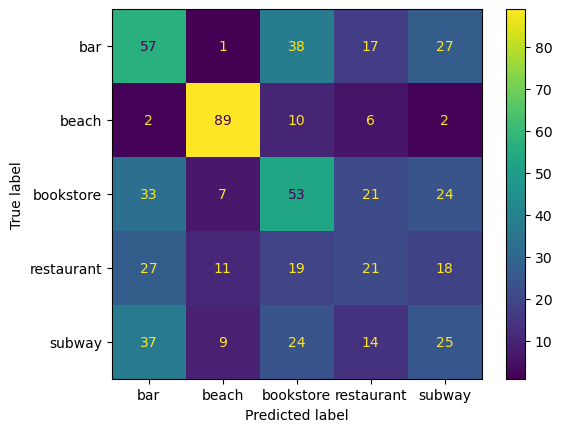

In [11]:
# Evaluation
Y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

class_correct = [0] * len(label_map)
class_total = [0] * len(label_map)

for i in range(len(Y_test)):
    label = Y_test[i]
    pred = Y_pred[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(len(label_map)):
    class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    class_prec = precision_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_rec = recall_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_f1 = f1_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
confusion_matrix_display.plot()
plt.show()

## Semi-supervised Decision Tree on Augmented Datasets
`img_path="final_dataset_augmentated"`

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Accuracy: 0.5721; Precision: 0.5745; Recall: 0.5867; F1: 0.5789
Class bar - Accuracy: 0.3667; Precision: 0.4622; Recall: 0.3667; F1-score: 0.4089
Class beach - Accuracy: 0.8125; Precision: 0.7339; Recall: 0.8125; F1-score: 0.7712
Class bookstore - Accuracy: 0.5099; Precision: 0.4783; Recall: 0.5099; F1-score: 0.4936
Class restaurant - Accuracy: 0.9204; Precision: 0.8889; Recall: 0.9204; F1-score: 0.9043
Class subway - Accuracy: 0.3238; Precision: 0.3091; Recall: 0.3238; F1-score: 0.3163


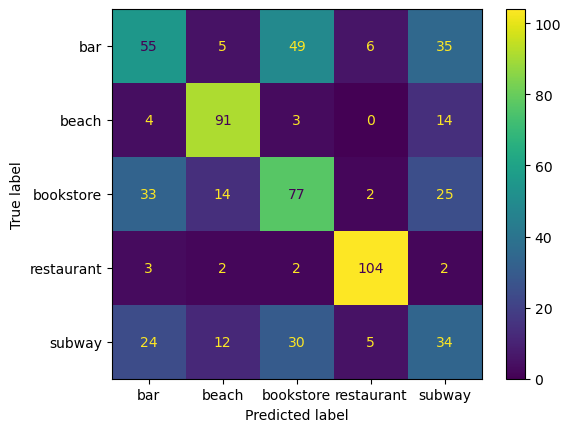

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
from PIL import Image
import dask.bag as db
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import platform
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "CPU"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

img_path = 'final_dataset_augmentated'
images = []
labels = []

label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}

device = torch.device('cpu')

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
for name, num in label_map.items():
    for img_name in os.listdir(os.path.join(img_path, name)):
        img_file = Image.open(os.path.join(img_path, name, img_name)).convert('RGB')
        img = transforms(img_file).to(device)
        images.append(img.cpu().numpy())
        labels.append(num)
    print(f"finish to read all {name} images")


X = np.array(images)
Y = np.array(labels)



X = X / 255.0

# Reshape
X_reshape = X.reshape(X.shape[0], -1)

num_cluster = 5
X_train, X_test, Y_train, Y_test = train_test_split(X_reshape,Y, test_size=0.2, random_state=42)

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)
Y_train_unlabeled = np.full(Y_unlabeled.shape, -1)

X_labeled_train = X_labeled
X_unlabeled_train = X_unlabeled
Y_unlabeled_train = Y_train_unlabeled
Y_labeled_train = Y_labeled

decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, min_samples_leaf=8)


for i in range(0,15):
    lprediction = decision_tree.fit(X_labeled_train, Y_labeled_train)
    
    Y_unlabeled_pred_proba = lprediction.predict_proba(X_unlabeled_train)
    Y_unlabeled_pred = lprediction.predict(X_unlabeled_train)

    
    confidence_scores = np.max(Y_unlabeled_pred_proba, axis=1)
    num_high_confidence = int(0.10 * len(Y_unlabeled_pred))
    top_indices = np.argsort(confidence_scores)[-num_high_confidence:]

    X_high_confidence = X_unlabeled_train[top_indices]
    Y_high_confidence = Y_unlabeled_pred[top_indices]

    
    mask = np.ones(len(X_unlabeled_train), dtype=bool)
    mask[top_indices] = False
    X_unlabeled_train = X_unlabeled_train[mask]
    Y_unlabeled_train = Y_unlabeled_train[mask]

    X_labeled_train = np.concatenate((X_labeled_train, X_high_confidence))
    Y_labeled_train = np.concatenate((Y_labeled_train, Y_high_confidence))

# Evaluation
Y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

class_correct = [0] * len(label_map)
class_total = [0] * len(label_map)

for i in range(len(Y_test)):
    label = Y_test[i]
    pred = Y_pred[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(len(label_map)):
    class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    class_prec = precision_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_rec = recall_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_f1 = f1_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
confusion_matrix_display.plot()
plt.show()

## Semi-supervised Decision Tree with Specific Hyperparameter Values
We use grid search on the supervised decision tree and we get the best hyperparameter value `{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}`. We will rerun the semi-supervised decision tree with these hyperparameter values.

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Accuracy: 0.5864; Precision: 0.5954; Recall: 0.5974; F1: 0.5942
Class bar - Accuracy: 0.4200; Precision: 0.5339; Recall: 0.4200; F1-score: 0.4701
Class beach - Accuracy: 0.7679; Precision: 0.7963; Recall: 0.7679; F1-score: 0.7818
Class bookstore - Accuracy: 0.5364; Precision: 0.5062; Recall: 0.5364; F1-score: 0.5209
Class restaurant - Accuracy: 0.9292; Precision: 0.8537; Recall: 0.9292; F1-score: 0.8898
Class subway - Accuracy: 0.3333; Precision: 0.2869; Recall: 0.3333; F1-score: 0.3084


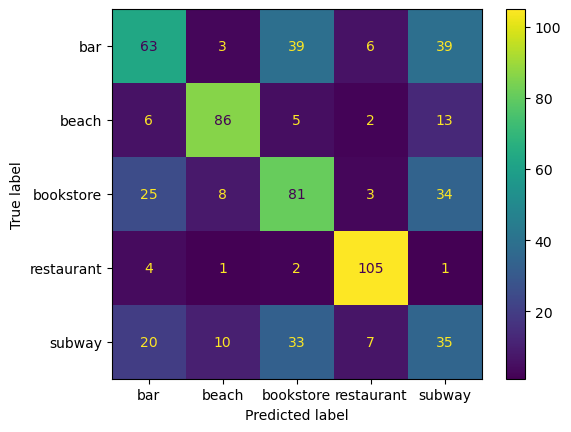

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
from PIL import Image
import dask.bag as db
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import platform
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "CPU"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

img_path = 'final_dataset_augmentated'
images = []
labels = []

label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}

device = torch.device('cpu')

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
for name, num in label_map.items():
    for img_name in os.listdir(os.path.join(img_path, name)):
        img_file = Image.open(os.path.join(img_path, name, img_name)).convert('RGB')
        img = transforms(img_file).to(device)
        images.append(img.cpu().numpy())
        labels.append(num)
    print(f"finish to read all {name} images")


X = np.array(images)
Y = np.array(labels)



X = X / 255.0

# Reshape
X_reshape = X.reshape(X.shape[0], -1)

num_cluster = 5
X_train, X_test, Y_train, Y_test = train_test_split(X_reshape,Y, test_size=0.2, random_state=42)

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)
Y_train_unlabeled = np.full(Y_unlabeled.shape, -1)

X_labeled_train = X_labeled
X_unlabeled_train = X_unlabeled
Y_unlabeled_train = Y_train_unlabeled
Y_labeled_train = Y_labeled

decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=30, min_samples_split=2, min_samples_leaf=1)


for i in range(0,15):
    lprediction = decision_tree.fit(X_labeled_train, Y_labeled_train)
    
    Y_unlabeled_pred_proba = lprediction.predict_proba(X_unlabeled_train)
    Y_unlabeled_pred = lprediction.predict(X_unlabeled_train)

    
    confidence_scores = np.max(Y_unlabeled_pred_proba, axis=1)
    num_high_confidence = int(0.10 * len(Y_unlabeled_pred))
    top_indices = np.argsort(confidence_scores)[-num_high_confidence:]

    X_high_confidence = X_unlabeled_train[top_indices]
    Y_high_confidence = Y_unlabeled_pred[top_indices]

    
    mask = np.ones(len(X_unlabeled_train), dtype=bool)
    mask[top_indices] = False
    X_unlabeled_train = X_unlabeled_train[mask]
    Y_unlabeled_train = Y_unlabeled_train[mask]

    X_labeled_train = np.concatenate((X_labeled_train, X_high_confidence))
    Y_labeled_train = np.concatenate((Y_labeled_train, Y_high_confidence))

# Evaluation
Y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

class_correct = [0] * len(label_map)
class_total = [0] * len(label_map)

for i in range(len(Y_test)):
    label = Y_test[i]
    pred = Y_pred[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(len(label_map)):
    class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    class_prec = precision_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_rec = recall_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    class_f1 = f1_score(Y_test, Y_pred, labels=[i], average='macro', zero_division=0)
    print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
confusion_matrix_display.plot()
plt.show()